In [19]:
import numpy as np
from numpy.polynomial.polynomial import polyval
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

### Generate (x,y) polynomial data

In [172]:
c_true = [1, -3, -0.5, 1]
sigma = 2

In [348]:
x_data = np.linspace(-3, 3, 20)
y_data = [polyval(x, c_true) + norm.rvs(loc=0, scale=sigma) for x in x_data]

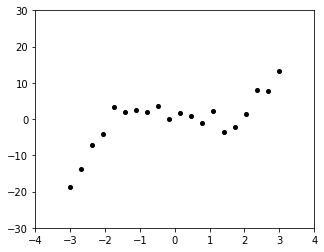

In [367]:
x = np.linspace(-3.2, 3.2, 60)
plt.figure(figsize=(5,4))
# plt.plot(x, polyval(x, c_true), '-', lw=1, label='true mean')
plt.plot(x_data, y_data, 'k.', label='data', ms=8)
plt.xlim([-4, 4])
plt.ylim([-30, 30])
plt.savefig('03-linear-regression-data.pdf', bbox_inches='tight')
plt.show()

### Fit different polynomials with MLE (using the OLS formula)

In [350]:
from numpy.linalg import inv
from numpy.linalg import norm as vector_norm

In [351]:
def generate_polynomial_features(x_data, degree):
    K = degree
    N = len(x_data)
    X = np.zeros([N, K+1])
    for i, x in enumerate(x_data):
        for k in range(0, K+1, 1):
            X[i,k] = x**k
    return X

In [352]:
def fit_MLE_ploynomial(X, y):
    c_MLE = inv(X.T.dot(X)).dot(X.T).dot(y_data)
    sigma2_MLE = 1.0/len(y) * vector_norm(y - X.dot(c_MLE))**2
    return c_MLE, sigma2_MLE

In [353]:
def log_likelihood(X, y, c, sigma2):
    N = len(y_data)
    log_like = 0
    log_like += - N/2.0 * np.log(sigma2)
    log_like += - 1.0/(2 * sigma2) * vector_norm(y - X.dot(c))**2
    return log_like

### Repeat for different degree polynomials

In [359]:
degrees = list(range(0, 12, 1))
dimensions = []
loglikes = []
c_MLEs = []
sigma2_MLEs = []
AICs = []
BICs = []

for degree in degrees:
    N = len(x_data)
    X = generate_polynomial_features(x_data, degree)
    c_MLE, sigma2_MLE = fit_MLE_ploynomial(X, y_data)
    loglike = log_likelihood(X, y_data, c_MLE, sigma2_MLE)
    dim = degree + 2
    AIC = -2 * (loglike - dim)
    BIC = -2 * (loglike - np.log(N)/2.0 * dim)
    
    c_MLEs.append(c_MLE)
    sigma2_MLEs.append(sigma2_MLE)
    dimensions.append(dim)
    loglikes.append(loglike)
    AICs.append(AIC)
    BICs.append(BIC)


BICs = np.array(BICs)
weights_by_BIC = np.zeros_like(BICs)
weights_by_BIC = np.exp(-0.5*(BICs - np.min(BICs)))
weights_by_BIC /= np.sum(weights_by_BIC)

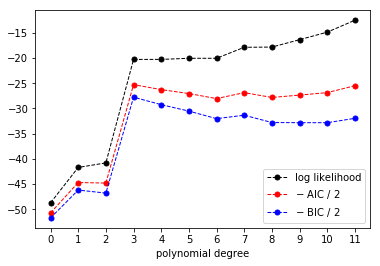

In [368]:
plt.plot(degrees, loglikes, 'k.--', ms=10, lw=1, label='log likelihood')
plt.plot(degrees, -0.5*np.array(AICs), 'r.--', ms=10, lw=1, label='$-$ AIC / 2')
plt.plot(degrees, -0.5*np.array(BICs), 'b.--', ms=10, lw=1, label='$-$ BIC / 2')
plt.xlabel('polynomial degree')
plt.xticks(degrees)
plt.legend()
plt.savefig('03-linear-regression-LL-AIC-BIC.pdf', bbox_inches='tight')
plt.show()

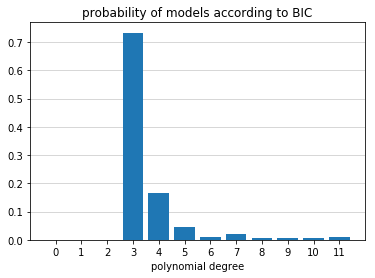

In [434]:
plt.bar(degrees, weights_by_BIC, zorder=2)
plt.xlabel('polynomial degree')
plt.title('probability of models according to BIC')
plt.xticks(degrees)
plt.grid(lw=0.5, zorder=0, axis='y')
plt.savefig('03-linear-regression-BIC-weights.pdf', bbox_inches='tight')

plt.show()

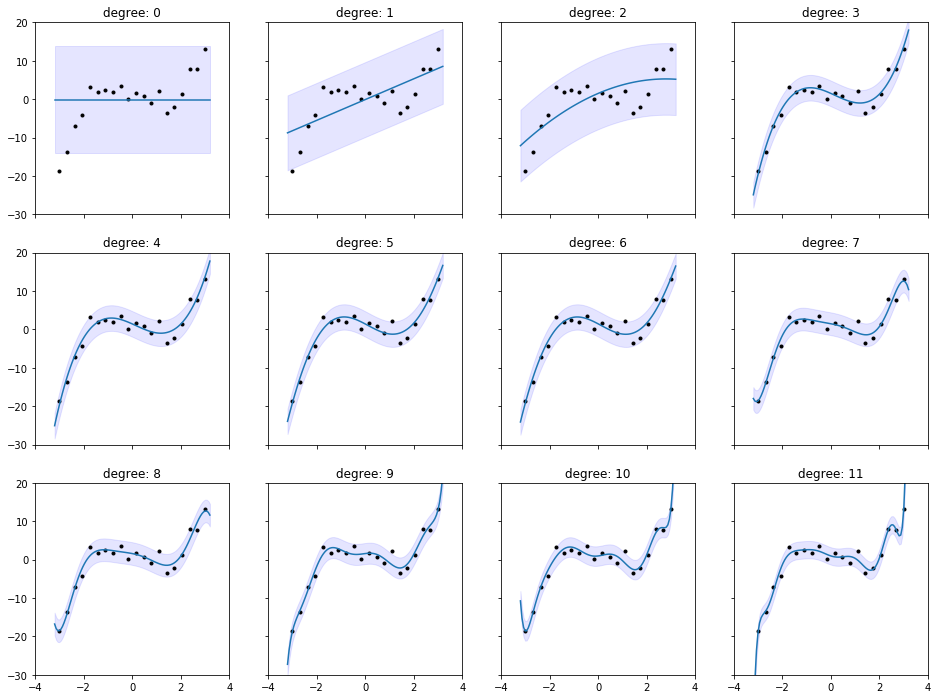

In [370]:
degrees_array = np.array(degrees).reshape(3, 4)

fig, rows = plt.subplots(3,4, figsize=(16,12), sharex=True, sharey=True)
x_draw = np.linspace(-3.2, 3.2, 100)
for row, degs in zip(rows, degrees_array):
    for ax, deg in zip(row, degs):
        ax.plot(x_data, y_data, 'k.', label='data', ms=6)
        ax.set_title('degree: ' + str(deg), fontsize=12)
        y_center = polyval(x_draw, c_MLEs[deg])
        width = 2*np.sqrt(sigma2_MLEs[deg])
        y_low = y_center - width
        y_high = y_center + width
        ax.plot(x_draw, y_center, '-')
        ax.fill_between(x_draw, y_low, y_high, color='blue', alpha=0.1)
ax.set_xlim([-4, 4])
ax.set_ylim([-30, 20])
plt.savefig('03-linear-regression-fits.pdf', bbox_inches='tight')
plt.show()

In [371]:
degrees

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [372]:
from scipy.stats import chi2

In [380]:
pvalues = [np.nan]
for deg in degrees[1:]:
    L1 = loglikes[deg]
    L0 = loglikes[deg-1]
    logLR = L1 - L0
    dof = 1
    
    pvalue = chi2.sf(2*logLR, dof)
    pvalues.append(pvalue)

In [381]:
np.log10(np.array(pvalues))

array([        nan, -3.75009021, -0.74289664, -9.83528775, -0.04798962,
       -0.29452969, -0.02652707, -1.43339294, -0.11736217, -1.06141655,
       -1.07743274, -1.52749964])

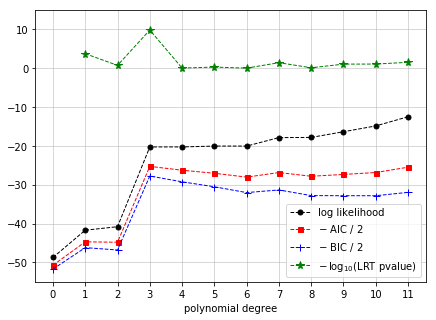

In [424]:
plt.figure(figsize=(7,5))
plt.plot(degrees, loglikes, 'k.--', ms=10, lw=1, label='log likelihood')
plt.plot(degrees, -0.5*np.array(AICs), 'rs--', ms=5, lw=1, label='$-$ AIC / 2')
plt.plot(degrees, -0.5*np.array(BICs), 'b+--', ms=7, lw=1, label='$-$ BIC / 2')
plt.plot(degrees, -np.log10(np.array(pvalues)), 'g*--', ms=8, lw=1, label='$-\,\log_{10}$(LRT pvalue)')
plt.xlabel('polynomial degree')
plt.xticks(degrees)
plt.legend(loc=4)
plt.ylim([-55, 15])
plt.grid(lw=0.5)
plt.savefig('03-linear-regression-LL-AIC-BIC-pvalue.pdf', bbox_inches='tight')
plt.show()

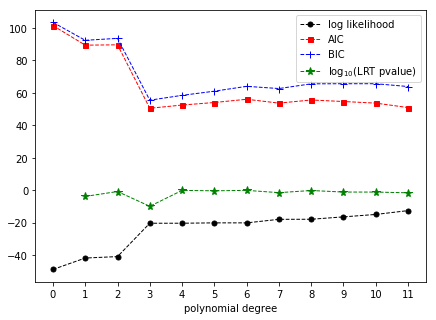

In [416]:
plt.figure(figsize=(7,5))
plt.plot(degrees, loglikes, 'k.--', ms=10, lw=1, label='log likelihood')
plt.plot(degrees, np.array(AICs), 'rs--', ms=5, lw=1, label='AIC')
plt.plot(degrees, np.array(BICs), 'b+--', ms=7, lw=1, label='BIC')
plt.plot(degrees, np.log10(np.array(pvalues)), 'g*--', ms=8, lw=1, label='$\log_{10}$(LRT pvalue)')
plt.xlabel('polynomial degree')
plt.xticks(degrees)
plt.legend(loc=0)
# plt.ylim([-62, 12])
plt.savefig('03-linear-regression-LL-AIC-BIC-pvalue-v2.pdf', bbox_inches='tight')
plt.show()